# UR5 Manipulator Sensor Data — Notebook 04: Deep Exploratory Data Analysis (EDA)

Objective: This notebook performs in-depth Exploratory Data Analysis (EDA) on the feature-engineered dataset. The goal is to:

- Visually validate the new features (lag, rolling stats, error metrics).

- Understand the temporal trends and volatility of the sensor signals.

- Identify potential anomalies or shifts in behavior that could indicate manipulator degradation.

- Inform the final model selection and feature scaling strategy.

Input Data:

- Feature Set: `../data/features/feature_set.parquet` (≈153k rows, ≈250 features).

---

## Step 1: Setup and Data Loading

We load the necessary libraries, including plotting packages, and the feature-rich dataset saved from Notebook 03.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# Define paths
feature_set_path = "../data/features/feature_set.parquet"

In [2]:
# Load the feature set
try:
    df = pd.read_parquet(feature_set_path)
    print(f"✔ Feature set loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {feature_set_path}. Please run Notebook 03 first.")

# Create a time index for plotting
df['TIME_INDEX'] = range(len(df))

display(df.head(2))

✔ Feature set loaded successfully. Shape: (153658, 127)


,ROBOT_TIME,ROBOT_TARGET_JOINT_POSITIONS (J1),ROBOT_TARGET_JOINT_POSITIONS (J2),ROBOT_TARGET_JOINT_POSITIONS (J3),ROBOT_TARGET_JOINT_POSITIONS (J4),ROBOT_TARGET_JOINT_POSITIONS (J5),ROBOT_TARGET_JOINT_POSITIONS (J6),ROBOT_ACTUAL_JOINT_POSITIONS (J1),ROBOT_ACTUAL_JOINT_POSITIONS (J2),ROBOT_ACTUAL_JOINT_POSITIONS (J3),...,ROBOT_JOINT_CONTROL_CURRENT_J1_ROLL_STD_50,ROBOT_ACTUAL_JOINT_VELOCITIES_J1_ROLL_MEAN_50,ROBOT_ACTUAL_JOINT_VELOCITIES_J1_ROLL_STD_50,ROBOT_TCP_FORCE_x_ROLL_MEAN_50,ROBOT_TCP_FORCE_x_ROLL_STD_50,ROBOT_TCP_FORCE_z_ROLL_MEAN_50,ROBOT_TCP_FORCE_z_ROLL_STD_50,ERROR_JOINT_POSITIONS_J1_ROLL_MEAN_50,ERROR_JOINT_POSITIONS_J1_ROLL_STD_50,TIME_INDEX
0,747.248,-26.880069,-79.911609,57.095392,-157.771764,-105.009613,-44.724779,-26.87662,-79.910908,57.096775,...,0.008602,0.0,0.0,-26.387519,0.60378,7.837572,0.65046,0.002732,0.001374,0
1,747.256,-26.880069,-79.911609,57.095392,-157.771764,-105.009613,-44.724779,-26.87662,-79.910225,57.096092,...,0.008602,0.0,0.0,-26.387519,0.60378,7.837572,0.65046,0.002732,0.001374,1


## Step 2: Univariate Analysis: Feature Distributions

We examine the distributions of key features, especially the newly created error metrics and rolling statistics. This helps identify skewness, zero-inflation, and potential outliers that may require scaling or transformation.

### 2.1 Distribution of Positional Error

We focus on the positional error for Joint 1 (J1), which is typically the most utilized joint and a key indicator of mechanical wear.

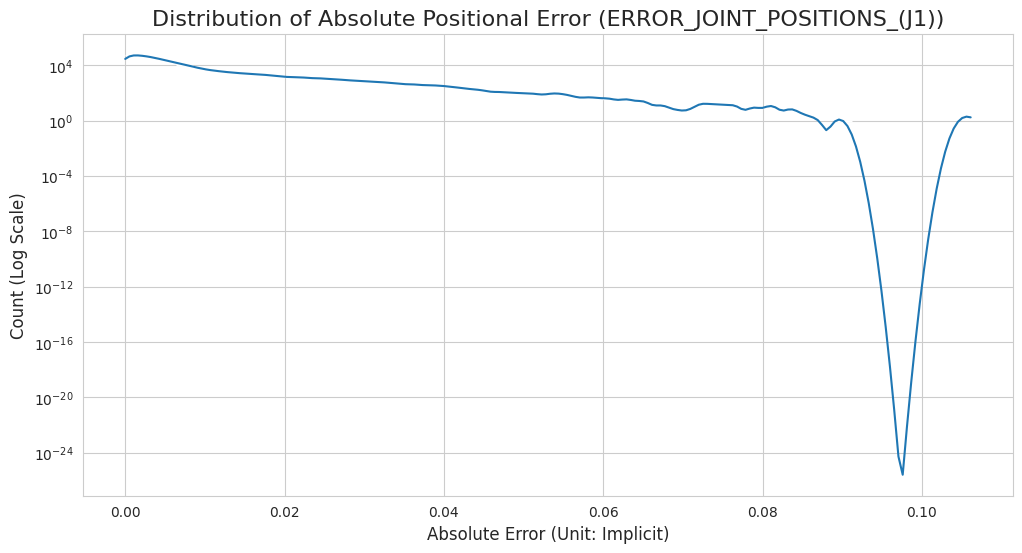

In [3]:
error_col = 'ERROR_JOINT_POSITIONS_(J1)'

plt.figure(figsize=(12, 6))
sns.histplot(df[error_col], bins=50, kde=True, log_scale=(False, True)) # Log scale on Y-axis for clarity
plt.title(f'Distribution of Absolute Positional Error ({error_col})')
plt.xlabel('Absolute Error (Unit: Implicit)')
plt.ylabel('Count (Log Scale)')
plt.show()

### 2.2 Distribution of Joint Volatility (Rolling Standard Deviation)

We check the distribution of the rolling standard deviation (ROLL_STD) for the actual current of J1. High volatility often signals mechanical friction or an unstable control loop.

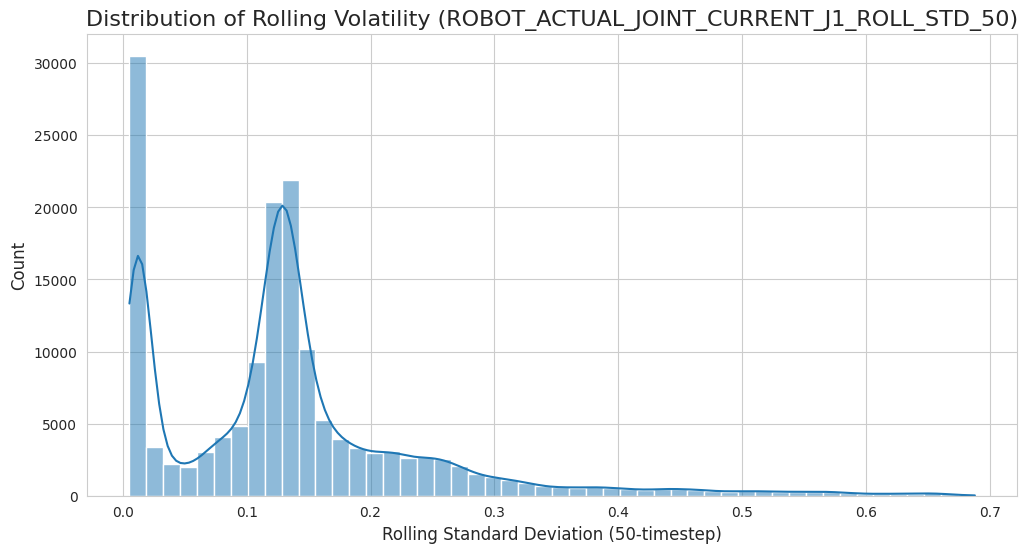

In [4]:
std_col = 'ROBOT_ACTUAL_JOINT_CURRENT_J1_ROLL_STD_50'

plt.figure(figsize=(12, 6))
sns.histplot(df[std_col], bins=50, kde=True)
plt.title(f'Distribution of Rolling Volatility ({std_col})')
plt.xlabel('Rolling Standard Deviation (50-timestep)')
plt.ylabel('Count')
plt.show()

## Step 3: Temporal Analysis: Trends and Anomalies

The most insightful EDA for time-series sensor data involves plotting features over time. This section visualizes the raw signals and the derived features to assess stability and pinpoint large deviations.

### 3.1 Raw Signal and Rolling Mean Trend Comparison

We plot the raw signal of a critical metric (J1 Current) against its 50-timestep rolling mean. This smooths out noise and highlights the underlying operational trend.

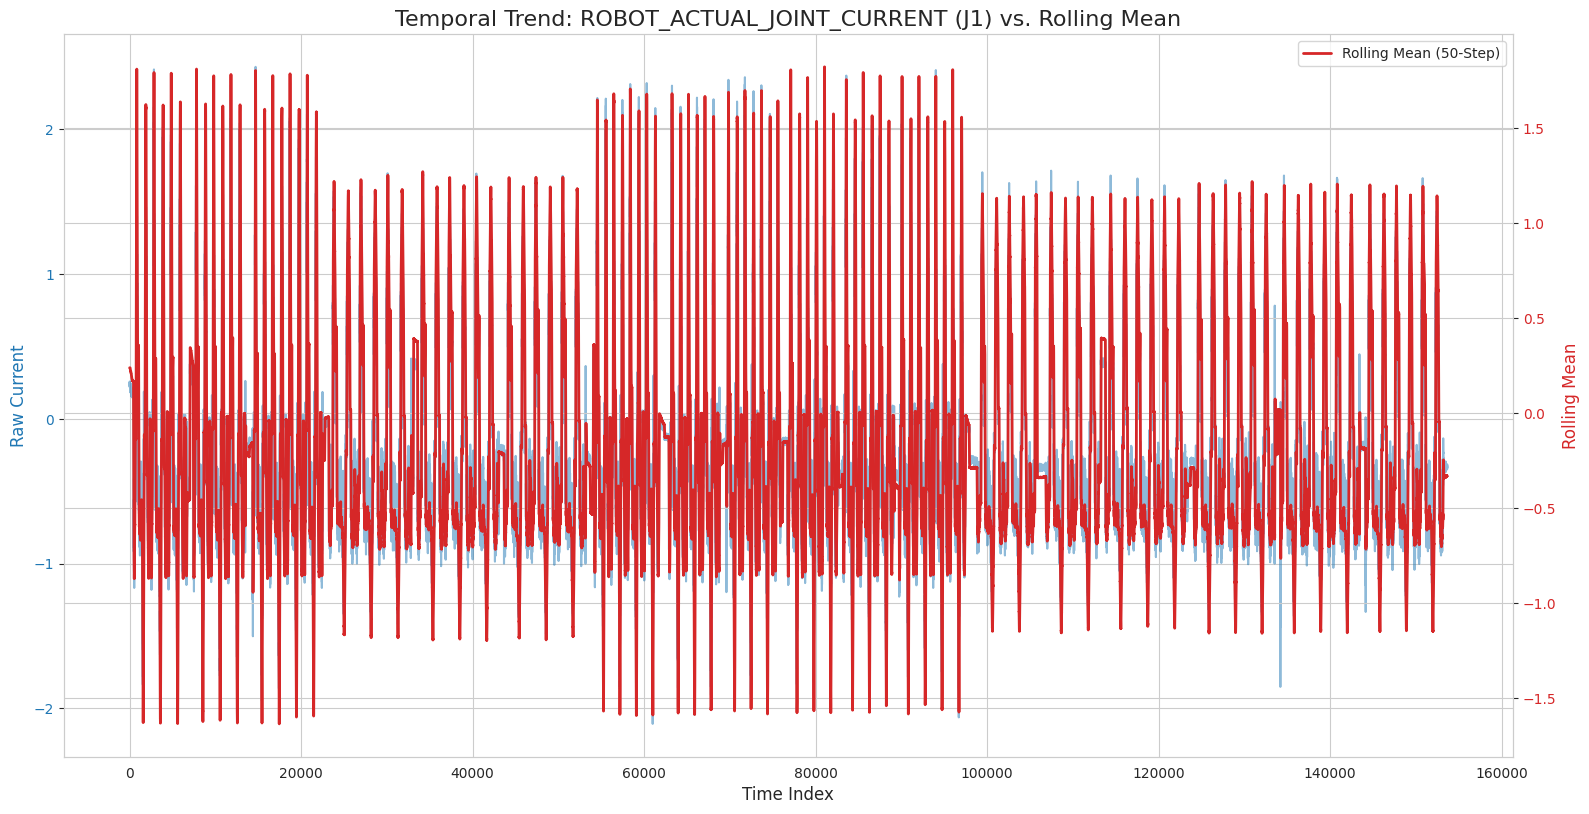

In [5]:
raw_col = 'ROBOT_ACTUAL_JOINT_CURRENT (J1)'
mean_col = 'ROBOT_ACTUAL_JOINT_CURRENT_J1_ROLL_MEAN_50'

fig, ax1 = plt.subplots(figsize=(16, 8))

# Plot Raw Signal (left y-axis)
color = 'tab:blue'
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Raw Current', color=color)
ax1.plot(df['TIME_INDEX'], df[raw_col], color=color, alpha=0.5, label='Raw Signal')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the Rolling Mean (smoother line)
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Rolling Mean', color=color)  
ax2.plot(df['TIME_INDEX'], df[mean_col], color=color, label='Rolling Mean (50-Step)', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Temporal Trend: {raw_col} vs. Rolling Mean')
plt.legend(loc='upper right')
plt.show()

### 3.2 Lag Feature Validation: Autocorrelation

We use a scatter plot to confirm that the lag features are capturing the dependence structure of the time series. A strong linear relationship indicates high autocorrelation, a fundamental characteristic of robot movement data.

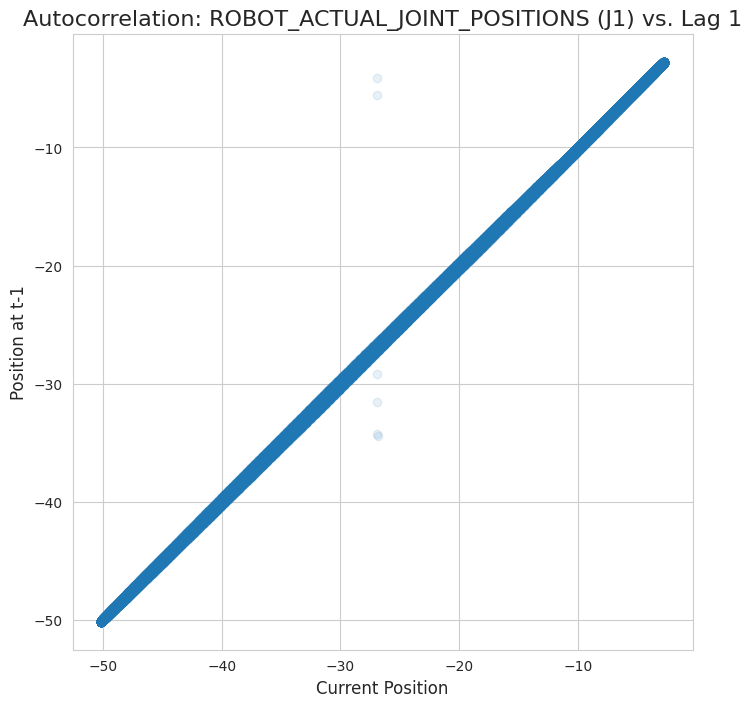

In [6]:
original_col = 'ROBOT_ACTUAL_JOINT_POSITIONS (J1)'
lag_col_1 = 'ROBOT_ACTUAL_JOINT_POSITIONS_J1_LAG_1'

plt.figure(figsize=(8, 8))
plt.scatter(df[original_col], df[lag_col_1], alpha=0.1)
plt.title(f'Autocorrelation: {original_col} vs. Lag 1')
plt.xlabel('Current Position')
plt.ylabel('Position at t-1')
plt.show()

### 3.3 Visualizing Anomalous Events (High Deviation)

We plot the positional error feature over time to clearly pinpoint where the robot's performance was worst. The peaks in this plot represent the most significant control deviations.

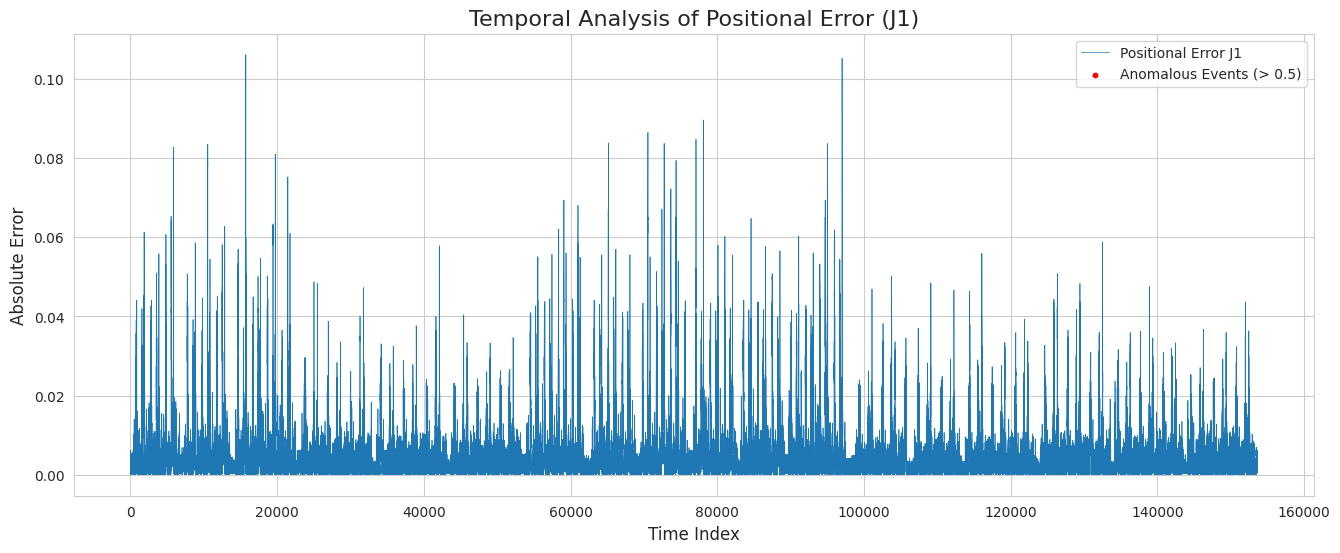

In [7]:
error_col = 'ERROR_JOINT_POSITIONS_(J1)'

plt.figure(figsize=(16, 6))
plt.plot(df['TIME_INDEX'], df[error_col], label='Positional Error J1', linewidth=0.5)

# Highlight potential anomalies (e.g., error greater than 0.5)
anomaly_threshold = 0.5
anomalies = df[df[error_col] > anomaly_threshold]
plt.scatter(anomalies['TIME_INDEX'], anomalies[error_col], color='red', marker='o', s=10, label=f'Anomalous Events (> {anomaly_threshold})')

plt.title(f'Temporal Analysis of Positional Error (J1)')
plt.xlabel('Time Index')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

# Step 4: Bivariate Analysis: Correlation Heatmap

We generate a correlation heatmap to understand the relationships between the original sensor readings and our newly engineered features. This helps identify redundant features and features that strongly correlate with each other, which is crucial for dimensionality reduction and model stability.

We select a subset of highly relevant features (raw signal, error, and rolling standard deviation) for clarity.

In [8]:
print([col for col in df.columns if 'ERROR' in col])

['ERROR_JOINT_POSITIONS_(J1)', 'ERROR_JOINT_POSITIONS_(J2)', 'ERROR_JOINT_POSITIONS_(J3)', 'ERROR_JOINT_POSITIONS_(J4)', 'ERROR_JOINT_POSITIONS_(J5)', 'ERROR_JOINT_POSITIONS_(J6)', 'ERROR_JOINT_VELOCITIES_(J1)', 'ERROR_JOINT_VELOCITIES_(J2)', 'ERROR_JOINT_VELOCITIES_(J3)', 'ERROR_JOINT_VELOCITIES_(J4)', 'ERROR_JOINT_VELOCITIES_(J5)', 'ERROR_JOINT_VELOCITIES_(J6)', 'ERROR_JOINT_CURRENT_(J1)', 'ERROR_JOINT_CURRENT_(J2)', 'ERROR_JOINT_CURRENT_(J3)', 'ERROR_JOINT_CURRENT_(J4)', 'ERROR_JOINT_CURRENT_(J5)', 'ERROR_JOINT_CURRENT_(J6)', 'ERROR_JOINT_POSITIONS_J1_ROLL_MEAN_50', 'ERROR_JOINT_POSITIONS_J1_ROLL_STD_50']


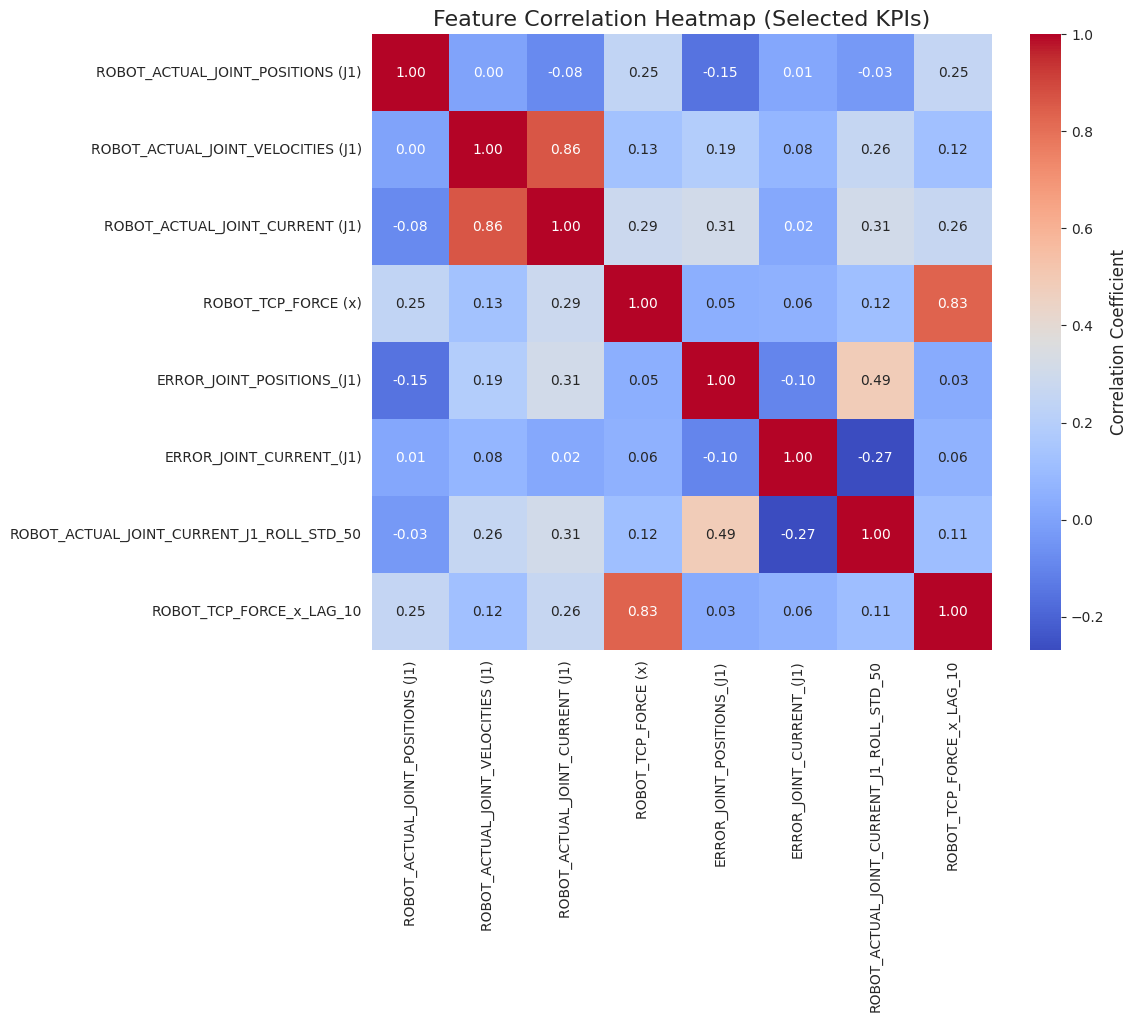

In [9]:
# Select a subset of highly relevant features for the heatmap
heatmap_cols = [
    'ROBOT_ACTUAL_JOINT_POSITIONS (J1)', 
    'ROBOT_ACTUAL_JOINT_VELOCITIES (J1)',
    'ROBOT_ACTUAL_JOINT_CURRENT (J1)',
    'ROBOT_TCP_FORCE (x)',
    'ERROR_JOINT_POSITIONS_(J1)',
    'ERROR_JOINT_CURRENT_(J1)',
    'ROBOT_ACTUAL_JOINT_CURRENT_J1_ROLL_STD_50',
    'ROBOT_TCP_FORCE_x_LAG_10'
]

# Calculate the correlation matrix
corr_matrix = df[heatmap_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature Correlation Heatmap (Selected KPIs)')
plt.show()

# Summary and Next Steps

This deep EDA provided critical insights into the feature set:

- Error Metrics: The distribution of positional error is highly concentrated near zero but exhibits a long tail, confirming the presence of significant high-deviation events (anomalies).

- Temporal Trends: Rolling features successfully capture the underlying operational trends of the raw, noisy signals.

- Anomaly Identification: Plots of the error features clearly isolate moments of high operational deviation, which will be the basis for defining the Y (target) variable in the next phase.

- Correlation: The heatmap provides a clear view of relationships (e.g., raw current is strongly correlated with its lagged and rolling features, as expected).

The feature set is robust, validated, and ready to be used for the final step: defining the target variable and establishing a baseline machine learning model.

---
Next Notebook → `05_Label_Creation.ipynb`